# Multi-Head Attention
- Multi-head attention is a mechanism that allows the model to jointly attend to information from different representation subspaces at different positions.
- $h$ is the number of heads, independent linear projections of the queries, keys, and values are computed $h$ times with different parameter matrices.
- $h$ attention-pooling outputs ae concatenated and projected to the final output.
- 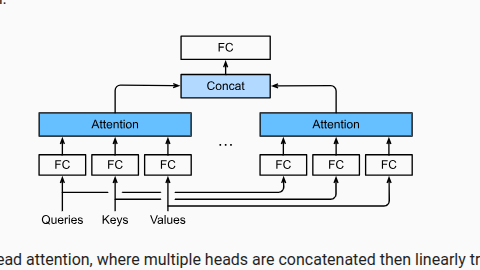
$$
\mathbf{h}_i = f(\mathbf{W}_i^{(q)} \mathbf{q}, \mathbf{W}_i^{(k)} \mathbf{k}, \mathbf{W}_i^{(v)} \mathbf{v}) \in \mathbb{R}^{p_v},
$$

$$
\mathbf{W}_o 
\begin{bmatrix}
\mathbf{h}_1 \\
\vdots \\
\mathbf{h}_h
\end{bmatrix} 
\in \mathbb{R}^{p_o}.
$$


In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
class MultiHeadAttention(d2l.Module):  #@save
    """Multi-head attention."""
    def __init__(self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super().__init__()
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
        self.W_o = nn.LazyLinear(num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # Shape of queries, keys, or values:
        # (batch_size, no. of queries or key-value pairs, num_hiddens)
        # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
        # After transposing, shape of output queries, keys, or values:
        # (batch_size * num_heads, no. of queries or key-value pairs,
        # num_hiddens / num_heads)
        queries = self.transpose_qkv(self.W_q(queries))
        keys = self.transpose_qkv(self.W_k(keys))
        values = self.transpose_qkv(self.W_v(values))

        if valid_lens is not None:
            # On axis 0, copy the first item (scalar or vector) for num_heads
            # times, then copy the next item, and so on
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # Shape of output: (batch_size * num_heads, no. of queries,
        # num_hiddens / num_heads)
        output = self.attention(queries, keys, values, valid_lens)
        # Shape of output_concat: (batch_size, no. of queries, num_hiddens)
        output_concat = self.transpose_output(output)
        return self.W_o(output_concat)

In [5]:
@d2l.add_to_class(MultiHeadAttention)  #@save
def transpose_qkv(self, X):
    """Transposition for parallel computation of multiple attention heads."""
    # Shape of input X: (batch_size, no. of queries or key-value pairs,
    # num_hiddens). Shape of output X: (batch_size, no. of queries or
    # key-value pairs, num_heads, num_hiddens / num_heads)
    X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
    # Shape of output X: (batch_size, num_heads, no. of queries or key-value
    # pairs, num_hiddens / num_heads)
    X = X.permute(0, 2, 1, 3)
    # Shape of output: (batch_size * num_heads, no. of queries or key-value
    # pairs, num_hiddens / num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])

@d2l.add_to_class(MultiHeadAttention)  #@save
def transpose_output(self, X):
    """Reverse the operation of transpose_qkv."""
    X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [7]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_heads, 0.5)
batch_size, num_queries, num_kvpairs = 2, 4, 6
valid_lens = torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
output = attention(X, Y, Y, valid_lens)
d2l.check_shape(output, (batch_size, num_queries, num_hiddens))